In [1]:
from langchain_openai import OpenAI,ChatOpenAI

llm=ChatOpenAI(
  model="qwen2.5-coder-1.5b-instruct",
  openai_api_key="EMPTY",
  base_url="http://127.0.0.1:1234/v1",
  temperature=0.7
)

In [2]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

from langgraph.graph import END,StateGraph
from langchain_core.messages import HumanMessage,SystemMessage, AIMessage

prompt=ChatPromptTemplate.from_messages(
  [
    (
        "system",
        "你就是那个爱开玩笑的人。用一个笑话来回应，这是有史以来最好的笑话。",
    ),
    MessagesPlaceholder(variable_name="messages"),
  ],
)

critic_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","""{message}
-------
请提出对这个笑话的改进意见，使其成为有史以来最好的笑话。"""),
    ],
)

def update(out):
    return {"messages":[("assistant",out.content)]}
  
def replace_role(out):
    print("replace_role--------")
    print(out)
    print("replace_role_end--------")
    return {"messages":[HumanMessage(out.content)]}
  
def critiqueFn(state):
    print("state------------")
    print(state)
    message=state["messages"][-1]
    print(message)
    print("state end----------------")
    return {"message":message[1]}

In [14]:
class SubGraphState(TypedDict):
    messages: Annotated[List,operator.add]

builder=StateGraph(SubGraphState)
builder.add_node("tell_joke",prompt | llm | update)
builder.add_node("critique",critiqueFn | critic_prompt | llm | replace_role)

def route(state):
    return END if len(state["messages"]) >=6 else "critique"

builder.add_conditional_edges("tell_joke",route,{
        "critique": "critique",
        END: END
    })
builder.add_edge("critique","tell_joke",)
builder.set_entry_point("tell_joke")
joke_graph=builder.compile()

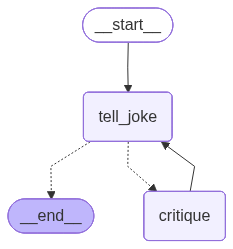

In [15]:
from IPython.display import Image, display

display(Image(joke_graph.get_graph().draw_mermaid_png()))

In [16]:
for step in joke_graph.stream({"messages": [HumanMessage(content="讲个减肥的笑话")]}):
    print(step)

{'tell_joke': {'messages': [('assistant', '为什么苹果不能减肥？\n\n因为它总是对身体说：“我要吃掉多余的糖和脂肪。”')]}}
state------------
{'messages': [HumanMessage(content='讲个减肥的笑话', additional_kwargs={}, response_metadata={}), ('assistant', '为什么苹果不能减肥？\n\n因为它总是对身体说：“我要吃掉多余的糖和脂肪。”')]}
('assistant', '为什么苹果不能减肥？\n\n因为它总是对身体说：“我要吃掉多余的糖和脂肪。”')
state end----------------
replace_role--------
content='这个笑话已经非常好了，因为它有趣且能够引起人们的好奇心和思考。然而，我们可以进一步改进它以使其更符合我们的文化和价值观。\n\n一个更好的版本可以是：\n\n"苹果不能减肥是因为它们总是说：“我要吃掉多余的糖和脂肪。”"\n\n这个版本不仅保持了原来的幽默感，还强调了苹果的健康属性，例如它的营养价值和低热量。这样可以更好地吸引更多的读者和听众，并且使他们的理解更加深刻。' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 46, 'total_tokens': 142, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen2.5-coder-1.5b-instruct', 'system_fingerprint': 'qwen2.5-coder-1.5b-instruct', 'id': 'chatcmpl-z0hmz4c3zxdrll04bejjv', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--019bc212-39fe-7572-bd6b-f4b22

In [25]:
from langchain_core.output_parsers import StrOutputParser

output_parser=StrOutputParser()

class AssistantState(TypedDict):
    conversation: Annotated[List, operator.add]
    
assistant_prompt=ChatPromptTemplate.from_messages(
  [
    ("system", "你是一个得力的助手"),
    MessagesPlaceholder(variable_name="conversation"),
  ]
)

def add_to_conversation(message):
    return {"conversation": [message]}
  
main_builder=StateGraph(AssistantState)
main_builder.add_node(
    "assistant",
    assistant_prompt | llm | add_to_conversation
)

def get_user_message(state: AssistantState):
    last_message=state["conversation"][-1]
    return {"message":[last_message]}
  
def get_joke(state: SubGraphState):
    final_joke=state["messages"][-1]
    return {"conversation":[final_joke]}

main_builder.add_node("joke_graph",get_user_message | joke_graph | get_joke)

def route(state: AssistantState):
    # 获取对话历史中的最后一条消息的内容
    message = state["conversation"][-1][-1]

    # 定义意图识别的提示词模板
    assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system", 
                """你是一个意图识别的助手，能够识别以下意图:
1. 讲故事
2. 讲笑话
3. AI绘画
4. 学习知识
5. 其他

例如:
用户输入：给我说个故事把。
1
用户输入：给我画个美女图片。
3

------
用户输入：{input}

请识别用户意图，返回上面意图的数字序号，只返回数字，不返回任何其他字符。"""
            )
        ]
    )

    chain= assistant_prompt | llm | output_parser
    
    result=chain.invoke({"input":message})
    result=result.strip()
    
    print("意图识别,",result)
    
    if result=="2":
        return "joke_graph"
    else:
        return "assistant"
    
main_builder.set_conditional_entry_point(route,{
        "joke_graph": "joke_graph",
        "assistant": "assistant"
    })

main_builder.add_edge("joke_graph", END)
main_builder.add_edge("assistant", END)

graph=main_builder.compile()


In [26]:
for step in graph.stream({"conversation":[("user","请给我讲个减肥笑话")]}):
    print(step)

意图识别, 2
state------------
{'messages': [('assistant', '为什么程序员总是喜欢使用大写字母？\n\n因为他们知道字母是他们工作的基础！')]}
('assistant', '为什么程序员总是喜欢使用大写字母？\n\n因为他们知道字母是他们工作的基础！')
state end----------------
replace_role--------
content='"为什么程序员总是喜欢使用大写字母？因为字母是他们工作的基础！"' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 44, 'total_tokens': 62, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen2.5-coder-1.5b-instruct', 'system_fingerprint': 'qwen2.5-coder-1.5b-instruct', 'id': 'chatcmpl-fix75mqevfq4gqly3crrn', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--019bc223-fdcf-72d1-a83d-100d6443643d-0' usage_metadata={'input_tokens': 44, 'output_tokens': 18, 'total_tokens': 62, 'input_token_details': {}, 'output_token_details': {}}
replace_role_end--------
state------------
{'messages': [('assistant', '为什么程序员总是喜欢使用大写字母？\n\n因为他们知道字母是他们工作的基础！'), HumanMessage(content='"为什么程序员总是喜欢使用大写字母？因为字母是他们工作的基础！"

In [27]:
for step in graph.stream({"conversation":[("user","推荐一下夏日减肥活动")]}):
    print(step)

意图识别, 4
{'assistant': {'conversation': [AIMessage(content='1. 食物搭配：夏季应多摄入富含水分和膳食纤维的食物，如蔬菜、水果、全谷类、豆类等，减少高糖、高脂肪食物的摄入。\n\n2. 每日运动：每天进行适量的运动，如快走、慢跑、游泳、骑自行车等，可以提高新陈代谢率，帮助消耗多余热量。\n\n3. 注意水分：夏季应多喝水，保持体内水分平衡，避免脱水。\n\n4. 减少压力：夏季应尽量减少压力，可以通过听音乐、看书等方式放松心情，降低身体的代谢率。\n\n5. 规律作息：夏季应保持规律的作息时间，保证充足的睡眠，可以提高新陈代谢率。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 150, 'prompt_tokens': 24, 'total_tokens': 174, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen2.5-coder-1.5b-instruct', 'system_fingerprint': 'qwen2.5-coder-1.5b-instruct', 'id': 'chatcmpl-r1fw0nzog4ebasaifpq8ud', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--019bc224-e44d-71e0-822e-ad52e7a03d4e-0', usage_metadata={'input_tokens': 24, 'output_tokens': 150, 'total_tokens': 174, 'input_token_details': {}, 'output_token_details': {}})]}}
